In [4]:
from dotenv import load_dotenv
import os
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, ToolMessage,AIMessage
from operator import add as add_messages
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.tools import tool
import gradio as gr

In [5]:
load_dotenv()

True

In [6]:
llm = ChatOpenAI(model="gpt-4",api_key=os.getenv("OPENAI_API_KEY") ,temperature=0)

In [10]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small",api_key=os.getenv("OPENAI_API_KEY"))

In [11]:
pdf_path = r"../../raw/Stock_Market_Performance_2024.pdf"

if not os.path.exists(pdf_path):
    raise FileNotFoundError(f"PDF file not found at path: {pdf_path}")

pdf_loader = PyPDFLoader(pdf_path)

#Check if the PDF was loaded correctly
try:   
    pages = pdf_loader.load()
    if not pages:
        raise ValueError("No pages were loaded from the PDF.")
except Exception as e:
    raise RuntimeError(f"Error loading PDF: {e}")

In [12]:
# Chunking Process
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

pages_plits = text_splitter.split_documents(pages)
if not pages_plits:
    raise ValueError("No text chunks were created from the PDF pages.")
print(f"Number of text chunks created: {len(pages_plits)}")


Number of text chunks created: 11


In [13]:
persist_directory = '../../raw/chroma_db'
collection_name = 'stock_market'
# check persist_directory exists
if not os.path.exists(persist_directory):
    os.makedirs(persist_directory)

try:
    vectordb = Chroma.from_documents(
        documents=pages_plits, # use the chunked documents
        embedding=embeddings, # use the OpenAI embeddings
        persist_directory=persist_directory,# specify the directory to persist the database
        collection_name=collection_name # name of the collection
        )
    print(f"Chroma vector store created and persisted at {persist_directory} with collection name '{collection_name}'")
except Exception as e:
    raise RuntimeError(f"Error creating or persisting Chroma vector store: {e}")


Chroma vector store created and persisted at ../../raw/chroma_db with collection name 'stock_market'


In [14]:
# Create a retriever from the vector store
retriever = vectordb.as_retriever(
    search_type="similarity",
      search_kwargs={"k": 3})

In [15]:
@tool
def retriever_tool(query: str) -> str:
    """Use this tool to answer questions about the content of the PDF document."""
    docs = retriever.invoke(query)
    if not docs:
        return "No relevant documents found."
    results = []
    for i,doc in enumerate(docs):
        results.append(f"Document {i+1}:\n{doc.page_content}\n")
    return "\n".join(results)

In [16]:
tools = [retriever_tool]

llm = llm.bind_tools(tools)

In [17]:
class AgentState(TypedDict):
    messages : Annotated[Sequence[BaseMessage], add_messages]

In [18]:
def should_continue(state: AgentState) -> bool:
    """Check if last messages contains tool calls"""
    result = state['messages'][-1]
    return hasattr(result, "tool_calls") and len(result.tool_calls) > 0

In [19]:
system_prompt = """
You are an intelligent AI assistant who answers questions about Stock Market Performance in 2024 based on the PDF document loaded into your knowledge base.
Use the retriever tool available to answer questions about the stock market performance data. You can make multiple calls if needed.
If you need to look up some information before asking a follow up question, you are allowed to do that!
Please always cite the specific parts of the documents you use in your answers.
"""

In [20]:
tools_dict = {tool.name: tool for tool in tools}

In [21]:
tools_dict

{'retriever_tool': StructuredTool(name='retriever_tool', description='Use this tool to answer questions about the content of the PDF document.', args_schema=<class 'langchain_core.utils.pydantic.retriever_tool'>, func=<function retriever_tool at 0x0000018872930310>)}

In [22]:
def call_llm(state: AgentState) -> AgentState:
    """Call the LLM with the current state messages"""
    messages = list(state['messages'])
    messages = [SystemMessage(content=system_prompt)] + messages
    response = llm.invoke(messages)
    return {'messages': [response]}

## struct response AIMessage
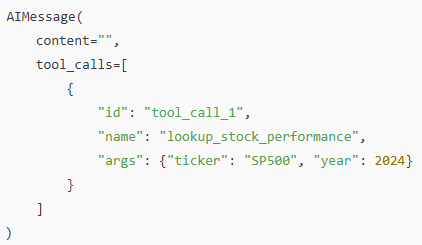

- 
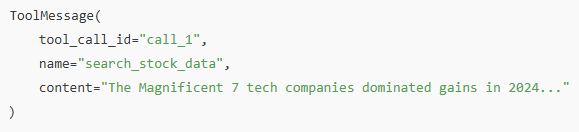

In [ ]:
def take_action(state: AgentState) -> AgentState:
    """Execute tool calls from the LLM's response."""

    tool_calls = state['messages'][-1].tool_calls
    results = []
    for t in tool_calls:
        print(f"Calling Tool: {t['name']} with query: {t['args'].get('query', 'No query provided')}")
        
        if not t['name'] in tools_dict: # Checks if a valid tool is present
            # print(f"\nTool: {t['name']} does not exist.")
            result = "Incorrect Tool Name, Please Retry and Select tool from List of Available tools."
        
        else:
            result = tools_dict[t['name']].invoke(t['args'].get('query', ''))
            print(f"Result length: {len(str(result))}")
            

        # Appends the Tool Message
        results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        results.append(ToolMessage(content=str(result)))

    print("Tools Execution Complete. Back to the model!")
    return {'messages': results}

In [24]:
graph = StateGraph(AgentState)

graph.add_node('llm',call_llm)
graph.add_node("retriever_agent",take_action)

graph.add_conditional_edges(
    "llm",
    should_continue,
    {True: "retriever_agent", False: END}
    
)
graph.add_edge("retriever_agent", "llm")
graph.set_entry_point("llm")

rag_agent = graph.compile()

In [ ]:
# show image graph


In [27]:
def running_agent():
    print("\n=== RAG AGENT===")
    
    while True:
        user_input = input("\nWhat is your question: ")
        if user_input.lower() in ['exit', 'quit']:
            break
            
        messages = [HumanMessage(content=user_input)] # converts back to a HumanMessage type

        result = rag_agent.invoke({"messages": messages})
        
        print("\n=== ANSWER ===")
        print(result['messages'][-1].content)


running_agent()


=== RAG AGENT===


KeyError: 'tool_call_id'

In [25]:
def stream_response(message, history):
    # Build conversation into LangChain format
    history_langchain_format = [system_prompt]
    for human, ai in history:
        history_langchain_format.append(HumanMessage(content=human))
        history_langchain_format.append(AIMessage(content=ai))

    if message:
        history_langchain_format.append(HumanMessage(content=message))

        partial_response = ""
        # stream qua app (state graph)
        for state in rag_agent.stream({"messages": history_langchain_format}, stream_mode="values"):
            new_msg = state["messages"][-1]  # lấy message mới nhất

            if isinstance(new_msg, AIMessage):
                if getattr(new_msg, "tool_calls", None):
                    partial_response += f"\n🤖 Gọi tool: {new_msg.tool_calls}"
                else:
                    partial_response += new_msg.content or ""
                yield partial_response

            elif new_msg.__class__.__name__ == "ToolMessage":
                partial_response += f"\n🛠️ Tool trả về: {new_msg.content}"
                yield partial_response
            # ---------------
            # if isinstance(new_msg, AIMessage):
            #     partial_response += new_msg.content or ""
            #     yield partial_response

# ---- UI ----
demo_interface = gr.ChatInterface(
    fn=stream_response,
    textbox=gr.Textbox(
        placeholder="Nhập tin nhắn...",
        container=False,
        autoscroll=True,
        scale=7,
    ),
    chatbot=gr.Chatbot(height=500),
)

if __name__ == "__main__":
    demo_interface.launch(debug=True, share=True)

C:\Users\nguye\AppData\Local\Temp\ipykernel_15764\3432685414.py:40: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot=gr.Chatbot(height=500),
d:\App\Anaconda\envs\rag_env\lib\site-packages\gradio\chat_interface.py:322: UserWarning: The gr.ChatInterface was not provided with a type, so the type of the gr.Chatbot, 'tuples', will be used.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


Traceback (most recent call last):
  File "d:\App\Anaconda\envs\rag_env\lib\site-packages\gradio\queueing.py", line 715, in process_events
    response = await route_utils.call_process_api(
  File "d:\App\Anaconda\envs\rag_env\lib\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
  File "d:\App\Anaconda\envs\rag_env\lib\site-packages\gradio\blocks.py", line 2220, in process_api
    result = await self.call_function(
  File "d:\App\Anaconda\envs\rag_env\lib\site-packages\gradio\blocks.py", line 1743, in call_function
    prediction = await utils.async_iteration(iterator)
  File "d:\App\Anaconda\envs\rag_env\lib\site-packages\gradio\utils.py", line 749, in async_iteration
    return await anext(iterator)
  File "d:\App\Anaconda\envs\rag_env\lib\site-packages\gradio\utils.py", line 854, in asyncgen_wrapper
    response = await iterator.__anext__()
  File "d:\App\Anaconda\envs\rag_env\lib\site-packages\gradio\chat_interface

Keyboard interruption in main thread... closing server.
